# Binary Classification

The goal of this notebook is to explore some datasets for binary classification (make_circles & make_moons in scikit-learn).

## 0. Preliminaries

In [1]:
# Import statements

from sklearn.datasets import make_circles, make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn

import matplotlib.pyplot as plt

from helper_functions import scatter_2class, accuracy_fn, plot_decision_boundary
from models import LinearRegressionModelV1, train_step_bin_classification, test_step_bin_classification

In [2]:
# Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device is {device}")

Device is cpu


In [3]:
# Random number seed
rns = 42

## 1. Load in, format & visualize data

In [4]:
# a. Load in data

# X, y = make_circles(n_samples=500, random_state=rns)

X, y = make_moons(n_samples=500, random_state=rns)

In [5]:
X.shape, y.shape

((500, 2), (500,))

In [6]:
# b. split data into train test datasets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rns)

In [7]:
X_train = torch.from_numpy(X_train).type(torch.float32).to(device)
X_test = torch.from_numpy(X_test).type(torch.float32).to(device)
y_train = torch.from_numpy(y_train).type(torch.float32).unsqueeze(dim=1).to(device)
y_test = torch.from_numpy(y_test).type(torch.float32).unsqueeze(dim=1).to(device)

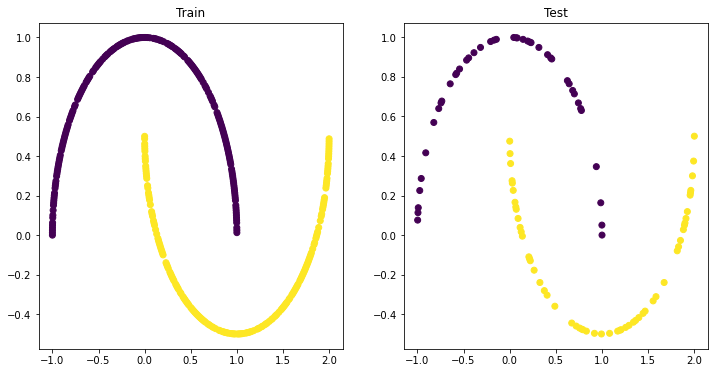

In [8]:
scatter_2class(train_data=X_train,
              train_labels=y_train,
              test_data=X_test,
              test_labels=y_test)

## 2. Build PyTorch Model

* Can use LinearRegressionModelV1 I think.

In [9]:
# a. Setup Model
model0 = LinearRegressionModelV1(in_dim=2,
                                hid_dim=5,
                                nl_type='tanh')

In [10]:
# b. Predict with untrained model

model0.eval()

with torch.inference_mode():
    y_logit = model0(X_test)
    
y_prob = torch.sigmoid(y_logit)
y_pred = torch.round(y_prob)

acc = accuracy_fn(y_pred, y_test)

n=10
print(f"Accuracy of untrained model is: {acc:.5f}")
print(f"First {n} predictions: \n Actual : {y_test[:n].T} \n Predict: {y_pred[:n].T}")

Accuracy of untrained model is: 0.57000
First 10 predictions: 
 Actual : tensor([[1., 1., 1., 1., 1., 1., 0., 0., 0., 0.]]) 
 Predict: tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])


## 3. Train PyTorch Model

* Must use Binary Cross Entropy loss function ( BCELoss() or BCEWithLogitsLoss() ) for Binary Classification task.
* Must write new train_step and test_step functions to deal with Logits output (convert logits to probs to preds)

In [11]:
# Setup Loss function and Optimizer
loss_fn = nn.BCEWithLogitsLoss()
# loss_fn = nn.BCELoss()

optimizer = torch.optim.SGD(params=model0.parameters(),
                           lr=0.1)


In [12]:
# Setup training loop

# a. Lists to keep track of model performance during training
epoch_count = []
loss_count = []
acc_count = []
test_loss_count = []
test_acc_count = []

epochs = 5000
freq_count = 100

# b. Loop through all data
for epoch in range(epochs):
    
    # c. train_step
    loss, acc = train_step_bin_classification(data = X_train,
                                    labels = y_train,
                                    model = model0,
                                    loss_fn = loss_fn,
                                    optimizer = optimizer)
    
    # d. Print what's happening every so often
    if epoch % freq_count == 0:
        
        # e. test step
        test_loss, test_acc = test_step_bin_classification(data = X_test,
                                                          labels = y_test,
                                                          model = model0,
                                                          loss_fn = loss_fn)
        
        # f. gather up results into lists for later plotting
        epoch_count.append(epoch)
        loss_count.append(loss.item())
        acc_count.append(acc.item())
        test_loss_count.append(test_loss.item())
        test_acc_count.append(test_acc.item())
        
        # g. print out performance during training
        print(f"Epoch: {epoch:4d} | loss: {loss:.5f} | accuracy: {acc:.3f} | test loss: {test_loss:.5f} | test acc: {test_acc:.3f}")



Epoch:    0 | loss: 0.71432 | accuracy: 0.482 | test loss: 0.69803 | test acc: 0.570
Epoch:  100 | loss: 0.35774 | accuracy: 0.858 | test loss: 0.35599 | test acc: 0.840
Epoch:  200 | loss: 0.27019 | accuracy: 0.890 | test loss: 0.27033 | test acc: 0.880
Epoch:  300 | loss: 0.25669 | accuracy: 0.892 | test loss: 0.25655 | test acc: 0.900
Epoch:  400 | loss: 0.24572 | accuracy: 0.897 | test loss: 0.24654 | test acc: 0.900
Epoch:  500 | loss: 0.22200 | accuracy: 0.908 | test loss: 0.22215 | test acc: 0.910
Epoch:  600 | loss: 0.17072 | accuracy: 0.930 | test loss: 0.16882 | test acc: 0.930
Epoch:  700 | loss: 0.10803 | accuracy: 0.962 | test loss: 0.10711 | test acc: 0.960
Epoch:  800 | loss: 0.06585 | accuracy: 0.990 | test loss: 0.06650 | test acc: 0.980
Epoch:  900 | loss: 0.04311 | accuracy: 1.000 | test loss: 0.04436 | test acc: 1.000
Epoch: 1000 | loss: 0.03049 | accuracy: 1.000 | test loss: 0.03183 | test acc: 1.000
Epoch: 1100 | loss: 0.02289 | accuracy: 1.000 | test loss: 0.0241

## 4. Visualize Results

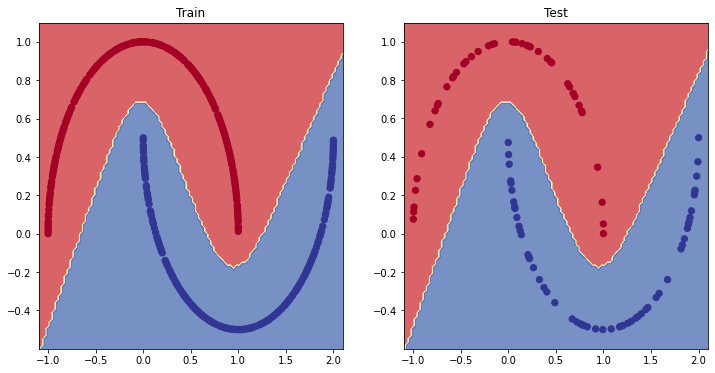

In [13]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model0, X_test, y_test)